In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve,auc
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

In [2]:
# CHOOSE DATASET

# Binary classification dataset
data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values
y = data.target.values 
X.shape

# Keep as DataFrame for named-column ops
df = data.data.copy()
y = np.where(data.target.values == "tested_positive", 1, 0).astype(np.float32)

# indices of features with invalid zeros
invalid_idx = [1, 2, 3, 4, 5, 7]

# count zeros per feature
zero_counts = (X[:, invalid_idx] == 0).sum(axis=0)
rows_with_zero = (X[:, invalid_idx] == 0).any(axis=1).sum()

print("Zeros per feature:\n", zero_counts)
print(f"Rows with ≥1 zero: {rows_with_zero} / {len(df)}")

(len(X), zero_counts, rows_with_zero)

# Drop columns 3 and 4 (0-based indexing)
X = np.delete(X, [3, 4], axis=1)

# Keep only rows where Glucose, BloodPressure, BMI are non-zero
mask = (X[:, [1, 2, 3, 4]] != 0).all(axis=1)
X = X[mask]
y = y[mask]

Zeros per feature:
 [  5  35 227 374  11   0]
Rows with ≥1 zero: 376 / 768


In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [6]:
num_epochs=100
lr=0.0003
dropout=0.2
batch_size=64

In [7]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 0.6790
Epoch [2/100], Loss: 0.6742
Epoch [3/100], Loss: 0.6587
Epoch [4/100], Loss: 0.6656
Epoch [5/100], Loss: 0.6516
Epoch [6/100], Loss: 0.6336
Epoch [7/100], Loss: 0.5991
Epoch [8/100], Loss: 0.5860
Epoch [9/100], Loss: 0.5891
Epoch [10/100], Loss: 0.5319
Epoch [11/100], Loss: 0.5621
Epoch [12/100], Loss: 0.5639
Epoch [13/100], Loss: 0.5179
Epoch [14/100], Loss: 0.4846
Epoch [15/100], Loss: 0.4708
Epoch [16/100], Loss: 0.4980
Epoch [17/100], Loss: 0.4592
Epoch [18/100], Loss: 0.4866
Epoch [19/100], Loss: 0.4744
Epoch [20/100], Loss: 0.5008
Epoch [21/100], Loss: 0.4847
Epoch [22/100], Loss: 0.4612
Epoch [23/100], Loss: 0.5070
Epoch [24/100], Loss: 0.4870
Epoch [25/100], Loss: 0.4629
Epoch [26/100], Loss: 0.4327
Epoch [27/100], Loss: 0.4445
Epoch [28/100], Loss: 0.4834
Epoch [29/100], Loss: 0.4770
Epoch [30/100], Loss: 0.4469
Epoch [31/100], Loss: 0.4556
Epoch [32/100], Loss: 0.4435
Epoch [33/100], Loss: 0.4415
Epoch [34/100], Loss: 0.4403
Epoch [35/100], Loss: 0

In [10]:
y_pred=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

ACC:0.8206896551724138


proba min/mean/max: 0.0027100993 0.332534 0.9272031


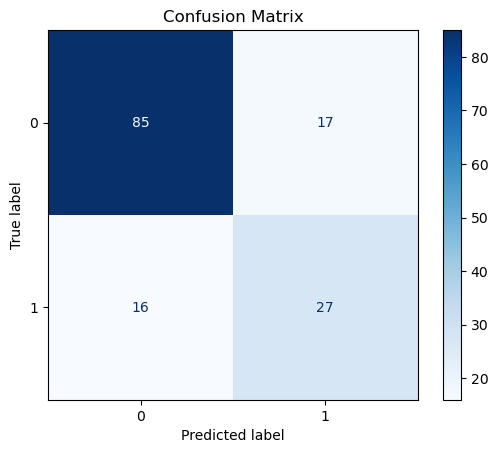

<Figure size 640x480 with 0 Axes>

In [11]:
model.eval()
device = next(model.parameters()).device

Xte_t = torch.as_tensor(Xte, dtype=torch.float32, device=device)
with torch.no_grad():
    logits = model(Xte_t)
    # make it 1D
    if logits.ndim > 1: logits = logits.squeeze(-1)
    y_proba = torch.sigmoid(logits).cpu().numpy()

print('proba min/mean/max:', y_proba.min(), y_proba.mean(), y_proba.max())
y_pred = (y_proba > 0.5).astype(int)

# ---- confusion matrix ----
cm = confusion_matrix(yte, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("../Plots/ConfusionMatrixMLP.pdf", format="pdf", bbox_inches="tight")

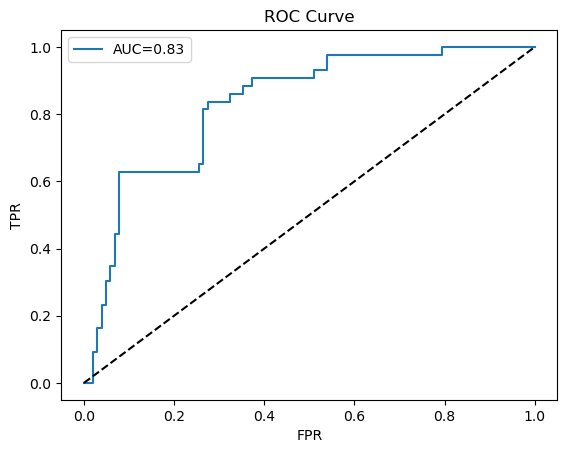

<Figure size 640x480 with 0 Axes>

In [12]:
fpr, tpr, _ = roc_curve(yte, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()
plt.savefig("../Plots/RoCMLP.pdf", format="pdf", bbox_inches="tight")